In [13]:
%matplotlib inline
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

In [8]:
from scipy.spatial import distance

class Data(object):
    # N points, k cluster, p dimensions
    def __init__(self, N, k, p):
        self.N = N
        self.k = k
        self.p = p
        self.true_center = []
        self.true_cluster_list = []
        self.data_set = []
        self.PIs = []
        self.means = []
        self.sigma = 0.0

    def init_board_gauss(self):
        n = float(self.N)/self.k
        X = []
        for i in range(self.k):
            c = ()
            # construct a random center point
            for j in range(self.p):
                c = c + (random.uniform(-1,1),)
            self.true_center.append(c)
            #s = random.uniform(0.05,0.5)
            s = 0.05
            x = []
            while len(x) < n:
                # need to change dimension
                lst = []
                for i in c:
                    lst.append(np.random.normal(i,s))
                point = np.array(lst)
                good = True
                for i in point:
                    if abs(i) >= 1:
                        good = False
                if good:
                    x.append(point)
            X.extend(x)
        X = np.array(X)[:self.N]
        return X

    def set_data(self, data):
        self.data_set = data
    # Taking in true center list, and the result center list
    def error_calculate(self,res):
        error = 0.0
        for i in range(self.k):
            min_dis = distance.euclidean(self.true_center[i],res[0])
            for j in range(self.k):
                # calculate the distance btw true center and kmean center
                dst = distance.euclidean(self.true_center[i],res[j])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            error += min_dis * min_dis
        # print "the error rate is: ", error
        return math.sqrt(error / (self.sigma * self.sigma * self.p))

    # calculate the true function enables more kmean center than true center
    # this is for the true center 
    def true_cost_function(self):
        cost = 0.0
        # loop through the data set
        for data in self.data_set:
            # min_dist is the distance to the first true center
            min_dis = distance.euclidean(data,self.true_center[0])
            # loop through the true center
            for i in range(self.k):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,self.true_center[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        return cost
    
    # this is for the cost function compared to the true center cost function
    def cost_function(self,res):
        cost = 0.0
        # loop through the whole dataset
        for data in self.data_set:
            min_dis = distance.euclidean(data,res[0])
            for i in range(len(res)):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,res[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        # the ratio of result center cost/ true center cost
        return cost/self.true_cost_function()
            

    def set_true_center(self, means):
        self.true_center = means

    # mean is a p dimensional vector, covarience is a p*p matrix
    # number_of_sample is n samples
    # return value: n*p matrix, generate n samples from N(mean,covarience)
    def generate_mult_normal_data(self, mean, covariance, num_of_samples):
        return np.random.multivariate_normal(mean,covariance, num_of_samples)

    # prob is list of probability that sums to 1
    # means is a p dimensional vector,covarience is a p*p matrix
    # number_of_samples is n samples
    # return value: generate n samples from the mixture of Gaussian
    def generate_mult_normal_based_prob(self, prob, means, covariance, num_of_samples):
        data_list = []
        # keep track which points belong to which cluster
        true_cluster_list = []
        for i in range(num_of_samples):
            # flip a coin to see which cluster the data point comes from
            random_num = random.random()
            sum = 0.0
            index = -1
            for p in prob:
                if random_num < sum:
                    break
                sum += p
                index = index + 1
            true_cluster_list.append(index)
            # call the generate_mult_normal_data rountine
            data_list.append(self.generate_mult_normal_data(means[index], covariance,1)[0])
        self.true_cluster_list = true_cluster_list
        return np.array(data_list)[:num_of_samples]
        #return (np.array(data_list)[:num_of_samples], true_cluster_list)
    def generate_data(self, dimension, p_sigma, number_of_cluster, number_of_points):
        # dimension
        self.p = dimension

        # sqrt of variance
        self.sigma = p_sigma

        # k is number of clusters
        self.k = number_of_cluster

        # n is number of points to be generated
        self.N = number_of_points

        # init a covariance matrix as identity matrix
        self.identity_matrix = np.identity(self.p)

        # covariance matrix
        covariance = self.sigma * self.sigma * self.identity_matrix
        # choose means from


        # means are from a normal distribution with center is all 0s and varience N(0,sigma squre identity matrix)
        mean = []
        for i in range(self.p):
            mean.append(0)
        # choose means, k is the number of centers/cluster
        self.means = self.generate_mult_normal_data(mean, covariance, self.k)

        self.set_true_center(self.means)

        # choose pis, ASA probabolity
        self.PIs = []
        for i in range(self.k):
            # every cluster has the same probability
            self.PIs.append(1.0/self.k)

        # generate n points from the mixture model
        self.data_set = self.generate_mult_normal_based_prob(self.PIs, self.means, covariance, self.N)

In [9]:
import random
import pylab
#color list
color_list = ([1,0,0],[0,1,0],[0,0,1],[1,1,0],[0,1,1],[1,1,0.7],[0.7,1,0],[1,0,0.7],[0.5,0.5,0], [0.5, 0, 0.5])

# create a data object
# number of points, k clusters, p dimensions
d = Data(1000, 3, 3)
# dimesion, sigma, cluster, # of points
d.generate_data(3, 0.6, 3, 1000)

# true center with true cluster
colors = ([color_list[i] for i in d.true_cluster_list])
pylab.scatter(d.data_set[:,0],d.data_set[:,1], c=colors)
pylab.title("Data Distribution with True Center")
pylab.figtext(0.135,0.85,'H is true center')
# hetagon means true center
pylab.scatter(d.true_center[:,0],d.true_center[:,1], marker='H', s = 500, linewidths=2)
pylab.show()
pylab.clf()

NameError: name 'Data' is not defined

number of estimated clusters : 3


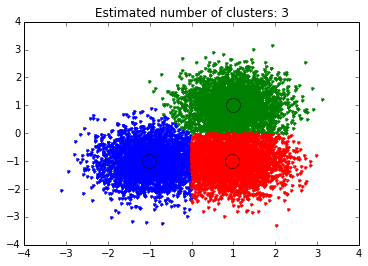

In [10]:
###############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]

X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

###############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
# estimate on Data d

bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=10000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

###############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [39]:
from math import exp
# define a gaussian kernel function
def GaussianKernel(v1, v2, sigma):
    return exp(-norm(v1-v2, 2)**2/(2.*sigma**2))

# this is a simple kernel
def simpleKernel(n1,n2,sigma):
    difference = float(n1) - float(n2)
    difference = pow(difference,2)
    difference = (-1.0*difference)/ (sigma**2)
    return exp(difference)

In [41]:
from scipy.spatial import distance

def K_Nearest_Neighbor(current, k, data):
    return_list = []
    index = 0
    distanceList = []
    for x in data:
        distanceList.append((distance.euclidean(current, x), x))
    distanceList.sort()
    #get the k nearest label
    for i in range (0, k):
        #append the first k smallest element
        return_list.append(distanceList[i][1])
    return return_list
# implement simple mean shift

In [45]:
import numpy as np

mu, sigma = 8.6, 5 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
#print s
print "Actual mean is ", mu

# random pick a point and look at the nearest 20 neighbors and take the average 
from random import randrange

threshold = 0.0000001
prev = 0.0
current = 1000.0

# indicate how many neighbors to look
number_of_neighbors = 50
sigma = 1.0 # this is for kernel sigma

# random choose a point
random_index = randrange(0,len(s))
# randomly initialize the mean
mean = s[random_index]
current = mean # update the current to the random picked mean
iteration = 0

# while less than threshold
while abs(current-prev) >= threshold:
    print "mean is ", mean
    count = 0 # count how many points added to the mean
    lst = K_Nearest_Neighbor(mean,number_of_neighbors, s)
    #print lst
    iteration = iteration + 1
    mean = 0.0
    nominator = 0.0
    denominator = 0.0
    for i in lst:
        # apply the kernel function
        # current is from the last iteration which get the nearest neighbor
        print i
        print "kernel result is ", simpleKernel(current,i,sigma)
        nominator = nominator + (current * simpleKernel(current,i,sigma))
        print "nominator ", nominator
        denominator = denominator + simpleKernel(current,i,sigma)
        print "denominator ", denominator
        #mean = mean + i
        count = count + 1
    # update mean
    mean = nominator*1.0/denominator
    prev = current
    current = mean
    print "current is ", current
    print "prev is ", prev


print "number of KNN ", iteration    
print "converged mode is ", current

Actual mean is  8.6
mean is  0.200016124371
0.200016124371
kernel result is  1.0
nominator  0.200016124371
denominator  1.0
0.232317337269
kernel result is  0.998957175765
nominator  0.39982366708
denominator  1.99895717576
0.251512463872
kernel result is  0.997351640127
nominator  0.599310076773
denominator  2.99630881589
0.27283952704
kernel result is  0.994710789418
nominator  0.798268273742
denominator  3.99101960531
0.304611587992
kernel result is  0.989119415458
nominator  0.996108105762
denominator  4.98013902077
0.355582620364
kernel result is  0.976089559813
nominator  1.19134175655
denominator  5.95622858058
0.365796735856
kernel result is  0.972891016143
nominator  1.38593564704
denominator  6.92911959672
0.382224471496
kernel result is  0.967345185604
nominator  1.57942028199
denominator  7.89646478233
0.000859070366229
kernel result is  0.961112768292
nominator  1.77165833299
denominator  8.85757755062
-0.004755543477
kernel result is  0.958935526819
nominator  1.963460900

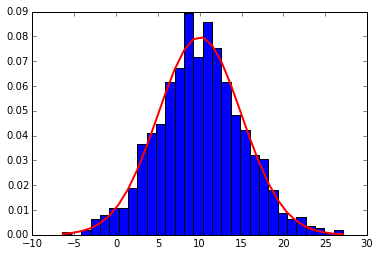

In [59]:
import matplotlib.pyplot as plt
s.sort()
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()